In [1]:
import os
import re
import sys
import pandas as pd
import numpy as np
import torchtext
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from nltk.tokenize import word_tokenize
from tqdm import tqdm as progressbar
from scipy.spatial import distance

### Loading preprocessed deduped data

In [2]:
df = pd.read_csv('../preprocessed/attribute.seqs.tsv', sep = '\t', names=['name', 'text'], dtype=object, encoding='utf-8').dropna()

In [3]:
classes=df.groupby(by=["name"]).count().reset_index()
classes_sorted = classes.sort_values(by='text', ascending=True) #.name.values
classes_sorted.tail(5)

,name,text
22,isolate_run,4483
29,sample_comment_sam,5003
0,bio_material_sam,9295
24,misc_param_sam,10739
10,description_sam,17233


### Loading pretrained FASTEXT

In [4]:
NAMESPACE='glove'

In [9]:
pretrained_vectors = torchtext.vocab.GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                               
100%|█████████▉| 399999/400000 [00:11<00:00, 35459.07it/s]


### Making directories to keep results

In [10]:
!mkdir -p ../results/$NAMESPACE-similarity-matrix ../results/$NAMESPACE-similar-pairs

In [11]:
!ls -l ../results/$NAMESPACE-similarity-matrix ../results/$NAMESPACE-similar-pairs

../results/glove-similar-pairs:
total 0

../results/glove-similarity-matrix:
total 0


## Checking vocabulary overlap  
Looks like FASTTEXT has n-gram vocab to expore, here we will consider just plane unigram/word.

In [12]:
%load_ext autoreload
%autoreload 2

from vocaverlap import VocabOverlap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%%time        
def if_oov(t):
    return t not in pretrained_vectors

vo = VocabOverlap(df[['name', 'text']].values).apply(if_oov)

with open(f'../preprocessed/attribute.token-freqs.{NAMESPACE}.info.pickle', 'wb') as f:
    pickle.dump(vo.info, f, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 269 ms, sys: 11.9 ms, total: 281 ms
Wall time: 280 ms


In [14]:
distribution = []

for k, v in vo.info.items():
    distribution.append([k, 1-v['oov_tokens']/v['tokens'], 1-v['oov_uniq']/v['uniq']])

distribution = sorted(distribution, key=lambda x :x[2], reverse=True)
df_distribution = pd.DataFrame(distribution, columns = ['name', 'r_tokens', 'r_uniq'])

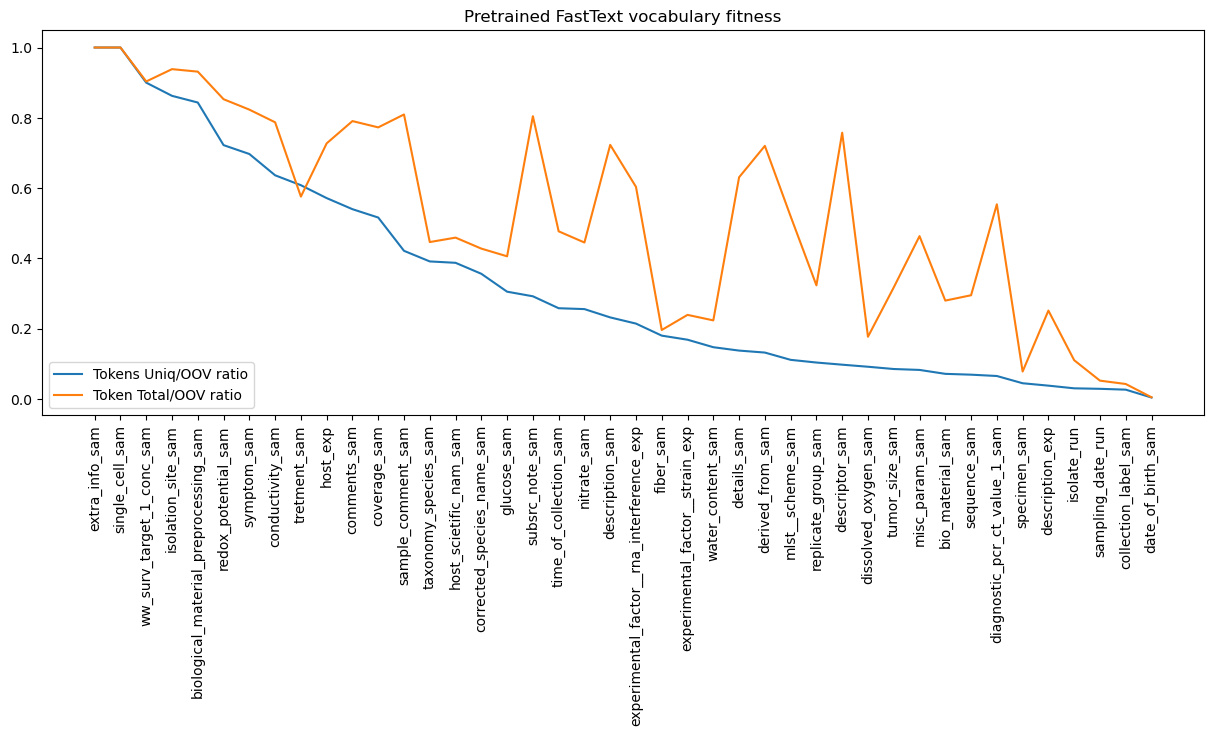

In [15]:
plt.figure(figsize=(15,5))
plt.plot(df_distribution['r_uniq'])
plt.plot(df_distribution['r_tokens'])
plt.title('Pretrained FastText vocabulary fitness')
plt.xticks(range(0, df_distribution.shape[0]), df_distribution['name'], rotation='vertical')
plt.legend(['Tokens Uniq/OOV ratio', 'Token Total/OOV ratio'], loc='lower left')
plt.show()

In [16]:
good_overlap = df_distribution[df_distribution.r_uniq>0.75]
good_overlap.to_csv(f'../preprocessed/attribute.{NAMESPACE}.75.overlap.tsv', sep = '\t', index=False, header=False)

### Making similarity matrixes and top similar pairs per attribute

In [17]:
def get_norm_sentence_vector(sentence):
    vec = np.sum(np.stack([pretrained_vectors[t].numpy() for t in sentence.split()]), axis=0)
    norm = np.linalg.norm(vec)
    if norm>0:
        return vec/norm
    return vec

def get_mean_sentence_vector(sentence):
    return np.mean(np.stack([pretrained_vectors[t].numpy() for t in sentence.split()]), axis=0)

In [18]:
def embed(row):
    return get_mean_sentence_vector(row.text)

In [19]:
%%time
for a in (pb := progressbar(classes_sorted.name.values, total=len(classes_sorted), file=sys.stdout)):
    pb.set_description(f' {a:60s}')
    
    data = df[df.name == a]

    # skipping misc_param_sam for time sake
    if data.shape[0] < 1 or a == 'misc_param_sam':
        continue
    
    sentences = data.text.values.tolist()
    embeddings = data.apply(embed, axis=1, result_type='expand')
    embeddings = embeddings/np.linalg.norm(embeddings, axis=1, keepdims=True)
    matrix = np.matmul(embeddings, embeddings.T)
    
    np.save(f'../results/{NAMESPACE}-similarity-matrix/{NAMESPACE}-{a}.similarity-score-matrix', matrix, allow_pickle = False)

    scores = []
    x = np.tril(matrix, k=-1)
    for r, c in zip(*np.where(x>0.7)):
        scores.append([a, x[r, c], sentences[r], sentences[c]])
        
    pd.DataFrame(scores, columns=['attr', 
                                  'score', 
                                  's1', 
                                  's2']).to_csv(f'../results/{NAMESPACE}-similar-pairs/{NAMESPACE}-{a}.similar-pairs.tsv', sep = '\t', index=False)


 description_sam                                             : 100%|██████████| 42/42 [02:22<00:00,  3.40s/it]
CPU times: user 2min 27s, sys: 8.59 s, total: 2min 36s
Wall time: 2min 22s


In [20]:
!ls ../results/$NAMESPACE-similarity-matrix/*

../results/glove-similarity-matrix/glove-bio_material_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-biological_material_preprocessing_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-collection_label_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-comments_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-conductivity_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-corrected_species_name_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-coverage_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-date_of_birth_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-derived_from_sam.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-description_exp.similarity-score-matrix.npy
../results/glove-similarity-matrix/glove-description_sam.similarity-score-matrix.npy
../results/glove-similarity-